# Optical Character Recognition (OCR) with OpenVINO™

This tutorial demonstrates how to perform optical character recognition (OCR) with OpenVINO models. It is a continuation of the [hello-detection](../hello-detection/hello-detection.ipynb) tutorial, which shows only text detection.

The [horizontal-text-detection-0001](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/horizontal-text-detection-0001/README.md) and [text-recognition-0014](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/text-recognition-0014/README.md) models are used together for text detection and then text recognition.


#### Table of contents:

- [Imports](#Imports)
- [Settings](#Settings)
- [Download Models](#Download-Models)
- [Select inference device](#Select-inference-device)
- [Object Detection](#Object-Detection)
    - [Load a Detection Model](#Load-a-Detection-Model)
    - [Load an Image](#Load-an-Image)
    - [Do Inference](#Do-Inference)
    - [Get Detection Results](#Get-Detection-Results)
- [Text Recognition](#Text-Recognition)
    - [Load Text Recognition Model](#Load-Text-Recognition-Model)
    - [Do Inference](#Do-Inference)
- [Show Results](#Show-Results)
    - [Show Detected Text Boxes and OCR Results for the Image](#Show-Detected-Text-Boxes-and-OCR-Results-for-the-Image)
    - [Show the OCR Result per Bounding Box](#Show-the-OCR-Result-per-Bounding-Box)
    - [Print Annotations in Plain Text Format](#Print-Annotations-in-Plain-Text-Format)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/optical-character-recognition/optical-character-recognition.ipynb" />


In [ ]:
# Install openvino package
%pip install -q "openvino>=2024.4.0" pillow opencv-python "matplotlib>=3.4"

## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import Markdown, display
from PIL import Image

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import load_image, device_widget

## Settings
[back to top ⬆️](#Table-of-contents:)


In [3]:
core = ov.Core()

model_dir = Path("model")
precision = "FP16"
detection_model = "horizontal-text-detection-0001"
recognition_model = "text-recognition-0014"

model_dir.mkdir(exist_ok=True)

## Download Models
[back to top ⬆️](#Table-of-contents:)

The next cells will download the detection and recognition models. If the models have been downloaded before, they will not be downloaded again.

In [4]:
from notebook_utils import download_ir_model

detection_model_url = f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{detection_model}/{precision}/{detection_model}.xml"

recognition_model_url = (
    f"https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{recognition_model}/{precision}/{recognition_model}.xml"
)

detection_model_path = download_ir_model(detection_model_url, model_dir / detection_model / precision)

recognition_model_path = download_ir_model(recognition_model_url, model_dir / recognition_model / precision)

'model/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.xml' already exists.
'model/horizontal-text-detection-0001/FP16/horizontal-text-detection-0001.bin' already exists.
'model/text-recognition-0014/FP16/text-recognition-0014.xml' already exists.
'model/text-recognition-0014/FP16/text-recognition-0014.bin' already exists.


## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [5]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Object Detection
[back to top ⬆️](#Table-of-contents:)

Load a detection model, load an image, do inference and get the detection inference result.

### Load a Detection Model
[back to top ⬆️](#Table-of-contents:)


In [6]:
detection_model = core.read_model(detection_model_path)
detection_compiled_model = core.compile_model(model=detection_model, device_name=device.value)

detection_input_layer = detection_compiled_model.input(0)

### Load an Image
[back to top ⬆️](#Table-of-contents:)


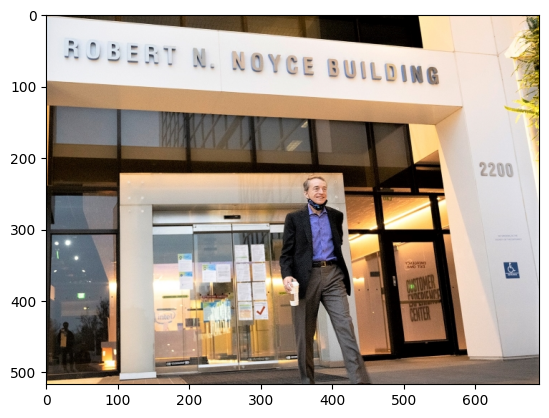

In [ ]:
# The `image_file` variable can point to a URL or a local image.
image_file = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg"

image = load_image("intel_rnb.jpg", image_file)

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = detection_input_layer.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

### Do Inference
[back to top ⬆️](#Table-of-contents:)

Text boxes are detected in the images and returned as blobs of data in the shape of `[100, 5]`. Each description of detection has the `[x_min, y_min, x_max, y_max, conf]` format.

In [8]:
output_key = detection_compiled_model.output("boxes")
boxes = detection_compiled_model([input_image])[output_key]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

### Get Detection Results
[back to top ⬆️](#Table-of-contents:)


In [9]:
def multiply_by_ratio(ratio_x, ratio_y, box):
    return [max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x for idx, shape in enumerate(box[:-1])]


def run_preprocesing_on_crop(crop, net_shape):
    temp_img = cv2.resize(crop, net_shape)
    temp_img = temp_img.reshape((1,) * 2 + temp_img.shape)
    return temp_img


def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0), "white": (255, 255, 255)}

    # Fetch image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box, annotation in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio.
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw a box based on the position. Parameters in the `rectangle` function are: image, start_point, end_point, color, thickness.
            cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add a text to an image based on the position and confidence. Parameters in the `putText` function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                # Create a background box based on annotation length.
                (text_w, text_h), _ = cv2.getTextSize(f"{annotation}", cv2.FONT_HERSHEY_TRIPLEX, 0.8, 1)
                image_copy = rgb_image.copy()
                cv2.rectangle(
                    image_copy,
                    (x_min, y_min - text_h - 10),
                    (x_min + text_w, y_min - 10),
                    colors["white"],
                    -1,
                )
                # Add weighted image copy with white boxes under a text.
                cv2.addWeighted(image_copy, 0.4, rgb_image, 0.6, 0, rgb_image)
                cv2.putText(
                    rgb_image,
                    f"{annotation}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

## Text Recognition
[back to top ⬆️](#Table-of-contents:)

Load the text recognition model and do inference on the detected boxes from the detection model.

### Load Text Recognition Model
[back to top ⬆️](#Table-of-contents:)


In [10]:
recognition_model = core.read_model(recognition_model_path)

recognition_compiled_model = core.compile_model(model=recognition_model, device_name=device.value)

recognition_output_layer = recognition_compiled_model.output(0)
recognition_input_layer = recognition_compiled_model.input(0)

# Get the height and width of the input layer.
_, _, H, W = recognition_input_layer.shape

### Do Inference
[back to top ⬆️](#Table-of-contents:)


In [11]:
# Calculate scale for image resizing.
(real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

# Convert the image to grayscale for the text recognition model.
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a dictionary to encode output, based on the model documentation.
letters = "#1234567890abcdefghijklmnopqrstuvwxyz"

# Prepare an empty list for annotations.
annotations = list()
cropped_images = list()
# fig, ax = plt.subplots(len(boxes), 1, figsize=(5,15), sharex=True, sharey=True)
# Get annotations for each crop, based on boxes given by the detection model.
for i, crop in enumerate(boxes):
    # Get coordinates on corners of a crop.
    (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, crop))
    image_crop = run_preprocesing_on_crop(grayscale_image[y_min:y_max, x_min:x_max], (W, H))

    # Run inference with the recognition model.
    result = recognition_compiled_model([image_crop])[recognition_output_layer]

    # Squeeze the output to remove unnecessary dimension.
    recognition_results_test = np.squeeze(result)

    # Read an annotation based on probabilities from the output layer.
    annotation = list()
    for letter in recognition_results_test:
        parsed_letter = letters[letter.argmax()]

        # Returning 0 index from `argmax` signalizes an end of a string.
        if parsed_letter == letters[0]:
            continue
        annotation.append(parsed_letter)
    annotations.append("".join(annotation))
    cropped_image = Image.fromarray(image[y_min:y_max, x_min:x_max])
    cropped_images.append(cropped_image)

boxes_with_annotations = list(zip(boxes, annotations))

## Show Results
[back to top ⬆️](#Table-of-contents:)

### Show Detected Text Boxes and OCR Results for the Image
[back to top ⬆️](#Table-of-contents:)

Visualize the result by drawing boxes around recognized text and showing the OCR result from the text recognition model.

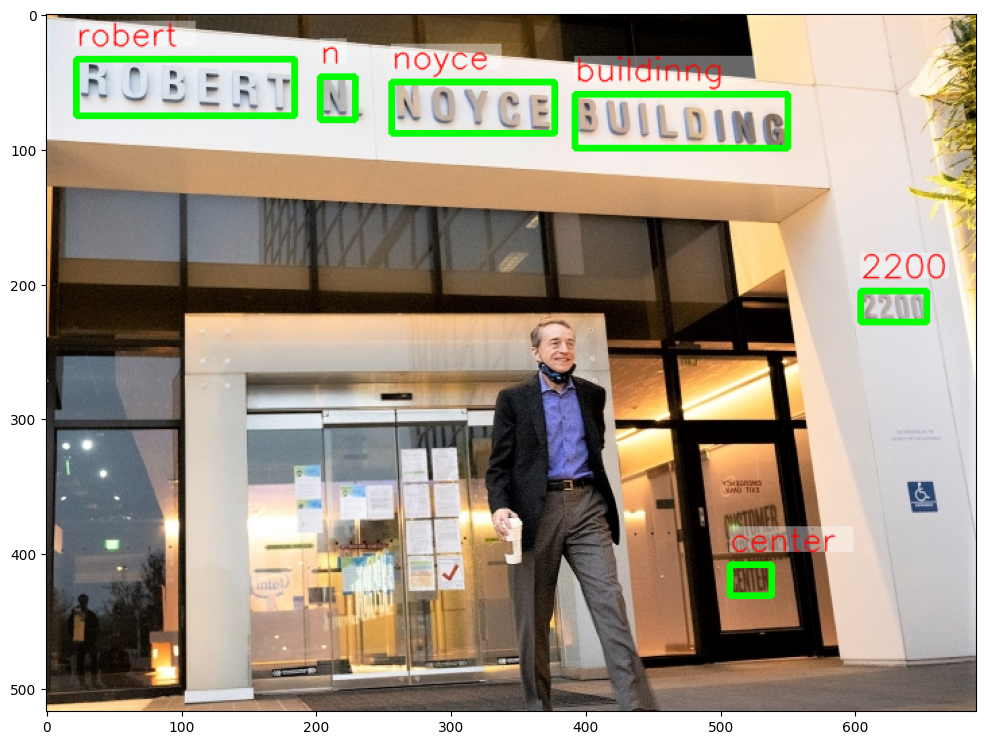

In [12]:
plt.figure(figsize=(12, 12))
plt.imshow(convert_result_to_image(image, resized_image, boxes_with_annotations, conf_labels=True));

### Show the OCR Result per Bounding Box
[back to top ⬆️](#Table-of-contents:)

Depending on the image, the OCR result may not be readable in the image with boxes, as displayed in the cell above. Use the code below to display the extracted boxes and the OCR result per box.

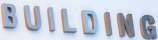

buildinng

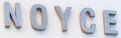

noyce

2200

n

center

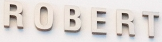

robert

In [13]:
for cropped_image, annotation in zip(cropped_images, annotations):
    display(cropped_image, Markdown("".join(annotation)))

### Print Annotations in Plain Text Format
[back to top ⬆️](#Table-of-contents:)

Print annotations for detected text based on their position in the input image, starting from the upper left corner.


In [14]:
[annotation for _, annotation in sorted(zip(boxes, annotations), key=lambda x: x[0][0] ** 2 + x[0][1] ** 2)]

['robert', 'n', 'noyce', 'buildinng', '2200', 'center']